# QAOA with Amazon Braket Hybrid Job and PennyLane
In this tutorial we show how to solve a max-cut problems using the Quantum Approximate Optimization Algorithm (QAOA). The QAOA algorithm is a hybrid quantum algorithms that involves optimizing an objective function by running both classical and quantum computers in an alternating manner. Amazon Braket Hybrid Job is a perfect solution for this type of problem. In the following, we show how to set up the problem, prepare input data and put together and the orchestration script.

## Problem setup
We first create and visualize a random graph for the max-cut problem with <code>networkx</code> package. Feel free to play with the number of nodes, <code>n</code>, and number of edges, <code>m</code>.

In [1]:
import tempfile
import time
import networkx as nx

from braket.aws import AwsQuantumJob, AwsSession

from braket.jobs.config import (
    InstanceConfig,
    OutputDataConfig,
    StoppingCondition
)
from braket.jobs.image_uris import Framework, retrieve_image

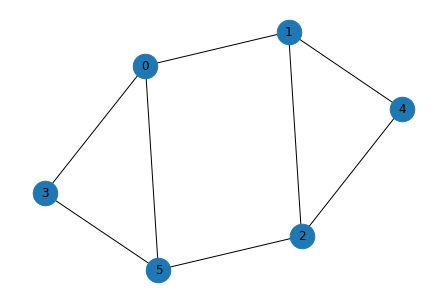

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967
    
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We also need to prepare the input data for training. The input data can be forwarded through a dictionary or through a S3 bucket. In this notebook, the input data is the random graph we created. We upload the graph to a s3 bucket and provide the URL of the s3 bucket to the orchestration script.

In [3]:
# Function to upload the graph to S3 in an adjacency list format
def setup_input_stream():
    with tempfile.NamedTemporaryFile() as temp_graph_file:
        # define the uri for our input data stream
        stream_s3_uri = aws_session.construct_s3_uri(
            aws_session.default_bucket(),
            "input-graph",
        )
        # Write graph to a temporary file
        nx.write_adjlist(graph, temp_graph_file.name)
        # Upload temporary file to S3
        aws_session.upload_to_s3(temp_graph_file.name, f"{stream_s3_uri}/input-data.adjlist")
    return stream_s3_uri

In [4]:
# Job output data will be sent to this bucket by default,
# unless output_data_config is specified in "AwsQuantumJob.create".
aws_session = AwsSession()
bucket = aws_session.default_bucket()
print(bucket)

amazon-braket-us-west-2-537332306153


## Specify hyperparameters and configurations
The hyperparameters can be forwarded to the algorithm script through the keyword argument <code>hyperparameters</code>. It usually includes, but not limited to, the variables that are required to define a training procedure, such as the number of iterations, or to set up an optimizer, such as the learning rate. Here, we pack these hyperparameters into a dictionary which will later become the input of the orchestration script. <code>device_arn</code> has a dedicated input channel so we do not include it in the hyperparameters.

In [5]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# Specify previous job arn to copy checkpoints from, or None to not copy checkpoints
copy_checkpoints_from_job = None
# copy_checkpoints_from_job = "arn:aws:braket:<region>:<your-account-id>:job/<job-name>"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}
if copy_checkpoints_from_job:
    hyperparameters['copy_checkpoints_from_job'] = copy_checkpoints_from_job

Braket Job has three pre-built containers. The base container does not include PennyLane, so we need to use either the TensorFlow or PyTorch container.

In [6]:
region = aws_session.region

# Choose the container based on which one we need.
if interface == 'autograd':
    # Base container does not have PennyLane, so we have to use the TF or PyTorch container
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'tf':
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'torch':
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

## Algorithm script
The complete algorithm script for solving the max-cut problem with QAOA is [here](qaoa_source/qaoa_algorithm_script.py). See [this page](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html) for details about using QAOA with PennyLane, and [this repo](https://github.com/aws/amazon-braket-examples) for example notebooks.

## Orchestration script
We have now finished preparing input data, algorithm script, hyperparameters and other configurations. It's time to submit out Braket Job!

- <code>device_arn</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>image_uri</code>: The path to a Docker container image.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>copy_checkpoints_from_job</code>: A string that specifies the job arn whose checkpoint you want to use in the current job.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values (as strings).
- <code>input_data</code>: A dictionary that contains our data or a path to Amazon S3 where our data was uploaded.
- <code>wait_until_complete</code>: If true, the function call will wait until the Braket Job is completedd, and will additionally print logs to the local console. Otherwise, it will run asynchronously.

In [ ]:
start_time = time.time()

job = AwsQuantumJob.create(
    device_arn=device_arn,
    source_module="qaoa_source",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="JobTest-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    # Relative to the current location
    entry_point="qaoa_source.qaoa_algorithm_script:start_here",
    copy_checkpoints_from_job=copy_checkpoints_from_job,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={
        "input-graph": setup_input_stream()
    },
    # Comment out the following line if you want to run the job
    # silently and asynchronously
    wait_until_complete=True,
)

end_time = time.time()

In [8]:
print(end_time - start_time)

320.56687593460083


## View results

After the job is completed, we can view the results and the metric we defined in the algorithm script.

In [10]:
print(job.result())

{'params': [[0.29045119576374073, 0.3090312068052205], [-0.04545138802088256, -0.11371989905871666]], 'cost': -4.903}


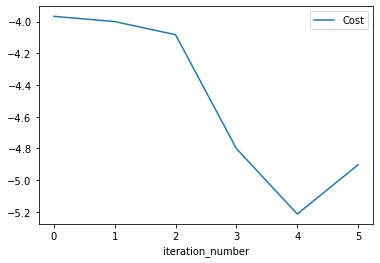

In [11]:
# A demonstration of plotting the metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

In [12]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
# time.sleep(120)
print(job.metrics())

{'timestamp': [1635951580.4037116, 1635951577.6235752, 1635951554.3002422, 1635951531.1797922, 1635951506.276847, 1635951482.2347124], 'Cost': [-4.903, -5.214, -4.801, -4.082, -3.999, -3.966], 'iteration_number': [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


## Summary
In this tutorial, we set up a max-cut problem with a random graph. The graph is uploaded to a S3 bucket and provided to our orchestration script through its URL. We use PennyLane as our quantum machine learning framework, therefore we can choose either the pre-built TensorFlow or PyTorch containers. Variables that are required to define the training process and the optimizer are passed as hypermeters. The results are retrieved after the QAOA algorithm is completed.